In [36]:
import os
import torch
import librosa
import librosa.display
import scipy
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from collections import defaultdict

## Constants

In [2]:
fs = 16e3 # [Hz] sampling frequency
windowLength = 256 # {from paper}
fftLength = windowLength
overlap = round(0.25 * windowLength) # overlap of 75% makes good prediction; {from paper}
window = scipy.signal.hamming(windowLength, sym=False) # Hamming window {from paper}
numSegments = 8
numFeatures = fftLength // 2 + 1

## Utilities

In [16]:
def read_audio(filepath, sample_rate, normalize=True):
    """Read an audio file and return it as a numpy array"""
    audio, sr = librosa.load(filepath, sr=sample_rate)
    #Normalization?
    if normalize:
        div_fac = 1 / np.max(np.abs(audio)) / 3.0
        audio = audio * div_fac
    return audio, sr
    
def remove_silent_frames(audio, filename):
    
    array_sum = np.sum(audio)
    array_has_nan = np.isnan(array_sum)
    
    if array_has_nan:
        print("NNNNNNNNNNNNNNNNNAAAAAAAAAAAAAAAAAAAAAAAAAAAANNNNNNNNNNNNNNNNNNNNNNNN", filename)
    
    trimed_audio = []
    indices = librosa.effects.split(audio, hop_length = overlap, top_db=20)

    for index in indices:
        trimed_audio.extend(audio[index[0]: index[1]])
    return np.array(trimed_audio)

def add_noise_to_clean_audio(clean_audio, noise_signal):
    """Adds noise to an audio sample"""
    if len(clean_audio) >= len(noise_signal):
        # print("The noisy signal is smaller than the clean audio input. Duplicating the noise.")
        while len(clean_audio) >= len(noise_signal):
            noise_signal = np.append(noise_signal, noise_signal)

    # Extract a noise segment from a random location in the noise file
    ind = np.random.randint(0, noise_signal.size - clean_audio.size)
    
    noise_segment = noise_signal[ind: ind + clean_audio.size]

    speech_power = np.sum(clean_audio ** 2)
    noise_power = np.sum(noise_segment ** 2)
    noisy_audio = clean_audio + np.sqrt(speech_power / noise_power) * noise_segment
    return noisy_audio

def extend_all_speaches_to_same_size(sample_speach_filenames):
    speaches = []
    
    max_length = 0
    for filename in sample_speach_filenames:
        sound_audio, sampl_rate_sound = read_audio(filename, sample_rate=fs)
        if max_length < len(sound_audio):
            max_length = len(sound_audio)
        speaches.append([sound_audio, sampl_rate_sound])
        
    for sound_data in speaches:
        sound_data[0] = np.pad(sound_data[0], (0, max_length - len(sound_data[0])), mode='constant')
        
    return speaches
        
def play_sound(audio, sample_rate):
    ipd.display(ipd.Audio(data=audio, rate=sample_rate)) 
    

In [17]:
def prepare_input_features(stft_features, numSegments, numFeatures):
    noisySTFT = np.concatenate([stft_features[:, 0:numSegments - 1], stft_features], axis=1)
    stftSegments = np.zeros((numFeatures, numSegments, noisySTFT.shape[1] - numSegments + 1))

    for index in range(noisySTFT.shape[1] - numSegments + 1):
        stftSegments[:, :, index] = noisySTFT[:, index:index + numSegments]
    return stftSegments

## Dataset

In [5]:
path_to_noise_dataset = "../../dataset/noise_dataset/audio/"
all_noise_filenames = glob.glob(os.path.join(path_to_noise_dataset, 'fold*', '*.*'))
#print(all_noise_filenames[0:10])

path_to_speach_dataset = "../../dataset/en/clips"
all_speach_filenames = glob.glob(os.path.join(path_to_speach_dataset, '*.*'))
#print(all_speach_filenames[0:10])
#print(len(all_speach_filenames))

## Sound

In [21]:
speach_sample_size = 100 # dataset has ~1e7 sounds, so we need smaller samplegg
sample_speach_filenames = random.sample(all_speach_filenames, speach_sample_size)

print(len(sample_speach_filenames))

train_set_percentage = 70 #%
validation_set_percentage = 20 #%
test_set_percentage = 10 #%

speach_filenames_train, speach_filenames_validation, speach_filenames_test = \
    np.split(sample_speach_filenames, \
             [int(speach_sample_size * train_set_percentage / 100.), \
              int(speach_sample_size * (train_set_percentage + validation_set_percentage) / 100.)])

print(len(speach_filenames_train))
print(len(speach_filenames_validation))
print(len(speach_filenames_test))

100
70
20
10


In [22]:
def fetch_data_for_nn(sample_speach_filenames):
    speach_data_for_nn = []
    noised_data_for_nn = []
    cnt = 0
    for filename in sample_speach_filenames:
         
        if cnt % 5 == 0:
            print(f"Completed: {cnt * 100 / len(sample_speach_filenames):.3f} %")
        cnt += 1
            
        sound_audio, sampl_rate_sound = read_audio(filename, sample_rate=fs)

        #play sound_audio without cutting empty voice
        #play_sound(sound_audio, sampl_rate_sound)

        sound_audio = remove_silent_frames(sound_audio, filename)

        speach_stft = librosa.stft(sound_audio, n_fft=fftLength, win_length=windowLength, hop_length=overlap, window=window, center=True)
        speach_stft_abs = np.abs(speach_stft)
        speach_stft_phase = np.angle(speach_stft)

        #speach_stft_abs_db = librosa.amplitude_to_db(speach_stft_abs,ref=np.max)
        #fig, ax = plt.subplots()
        #img = librosa.display.specshow(speach_stft_abs_db, y_axis='linear', x_axis='time', ax=ax)
        #ax.set_title('Clear speach')
        #fig.colorbar(img, ax=ax, format="%+2.0f dB")

        random_noise_signal_index = np.random.randint(0, len(all_noise_filenames) - 1)
        noise_audio, sampl_rate_noise = read_audio(all_noise_filenames[random_noise_signal_index], sample_rate=fs)

        noise_audio = remove_silent_frames(noise_audio, filename)

        noise_stft = librosa.stft(noise_audio, n_fft=fftLength, win_length=windowLength, hop_length=overlap, window=window, center=True)
        noise_stft_abs = np.abs(noise_stft)
        noise_stft_phase = np.angle(noise_stft)

        #noise_stft_abs_db = librosa.amplitude_to_db(noise_stft_abs,ref=np.max)


        noise_and_speach = add_noise_to_clean_audio(sound_audio, noise_audio)    

        noise_and_speach_stft = librosa.stft(noise_and_speach, n_fft=fftLength, win_length=windowLength, hop_length=overlap, window=window, center=True)
        noise_and_speach_stft_abs = np.abs(noise_and_speach_stft)

        #noise_and_speach_stft_abs_db = librosa.amplitude_to_db(noise_and_speach_stft_abs,ref=np.max)
        #fig, ax = plt.subplots()
        #img = librosa.display.specshow(noise_and_speach_stft_abs_db, y_axis='linear', x_axis='time', ax=ax)
        #ax.set_title('Noisy speach')
        #fig.colorbar(img, ax=ax, format="%+2.0f dB")

    #    speach_data_for_nn.append(speach_stft_abs)
    #    noised_data_for_nn.append(noise_and_speach_stft_abs)    

        #print(noise_and_speach_stft_abs.shape)

        noise_and_speach_chunks = prepare_input_features(noise_and_speach_stft_abs, numSegments, numFeatures)

        #print(noise_and_speach_chunks.shape, speach_stft_abs.shape)

        noise_and_speach_chunks = np.transpose(noise_and_speach_chunks, (2, 0, 1))
        speach_stft_abs = np.transpose(speach_stft_abs, (1, 0))
    #    noise_stft_phase = np.transpose(noise_stft_phase, (1, 0))

        #print(noise_and_speach_chunks.shape, speach_stft_abs.shape)

        speach_data_for_nn.append(speach_stft_abs)
        noised_data_for_nn.append(noise_and_speach_chunks)

        #play sound_audio
        #play_sound(sound_audio, sampl_rate_sound)
        #play noise_audio
        #play_sound(noise_audio, sampl_rate_noise)
        #play noise_and_speach
        #play_sound(noise_and_speach, sampl_rate_sound)

        #print(noise_and_speach_stft_abs.shape)
        #print("--")

    #print("++")
    speach_data_for_nn = np.concatenate(speach_data_for_nn)
    speach_data_for_nn = speach_data_for_nn[:,:,None]
    noised_data_for_nn = np.concatenate(noised_data_for_nn)
    
    return noised_data_for_nn, speach_data_for_nn

In [23]:
# train data fetch
train_noised_data_for_nn, train_speach_data_for_nn = fetch_data_for_nn(speach_filenames_train)
train_noised_data_for_nn = train_noised_data_for_nn.astype(np.float32)
train_speach_data_for_nn = train_speach_data_for_nn.astype(np.float32)


print(train_noised_data_for_nn.shape, train_speach_data_for_nn.shape)

# validation data fetch
validation_noised_data_for_nn, validation_speach_data_for_nn = fetch_data_for_nn(speach_filenames_validation)
validation_noised_data_for_nn = validation_noised_data_for_nn.astype(np.float32)
validation_speach_data_for_nn = validation_speach_data_for_nn.astype(np.float32)

print(validation_noised_data_for_nn.shape, validation_speach_data_for_nn.shape)

# test data fetch
test_noised_data_for_nn, test_speach_data_for_nn = fetch_data_for_nn(speach_filenames_test)
test_noised_data_for_nn = test_noised_data_for_nn.astype(np.float32)
test_speach_data_for_nn = test_speach_data_for_nn.astype(np.float32)

print(test_noised_data_for_nn.shape, test_speach_data_for_nn.shape)



Completed: 0.000 %
Completed: 7.143 %
Completed: 14.286 %
Completed: 21.429 %
Completed: 28.571 %
Completed: 35.714 %
Completed: 42.857 %
Completed: 50.000 %
Completed: 57.143 %
Completed: 64.286 %
Completed: 71.429 %
Completed: 78.571 %
Completed: 85.714 %
Completed: 92.857 %
(52870, 129, 8) (52870, 129, 1)
Completed: 0.000 %
Completed: 25.000 %
Completed: 50.000 %
Completed: 75.000 %
(18829, 129, 8) (18829, 129, 1)
Completed: 0.000 %
Completed: 50.000 %
(8858, 129, 8) (8858, 129, 1)


## Dataset and Dataloader

In [24]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

batch_size = 32

In [25]:
train_set=TensorDataset(torch.from_numpy(train_noised_data_for_nn), torch.from_numpy(train_speach_data_for_nn))
train_loader=DataLoader(train_set, batch_size=batch_size, shuffle=True)


validation_set=TensorDataset(torch.from_numpy(validation_noised_data_for_nn), torch.from_numpy(validation_speach_data_for_nn))
validation_loader=DataLoader(train_set, batch_size = batch_size, shuffle = True)

#data_set = {'train': train_l}

test_set=TensorDataset(torch.from_numpy(test_noised_data_for_nn), torch.from_numpy(test_speach_data_for_nn))
test_loader=DataLoader(train_set, batch_size = batch_size, shuffle = True)



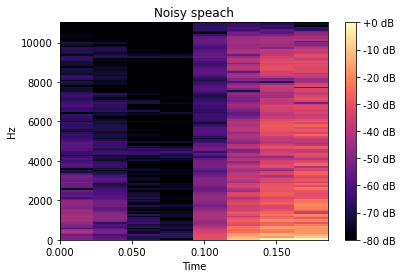

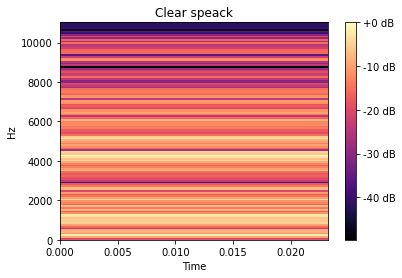

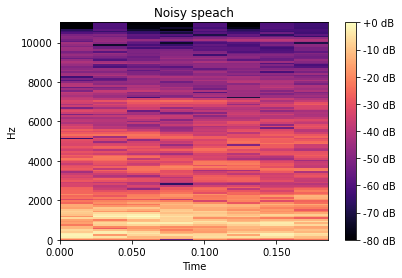

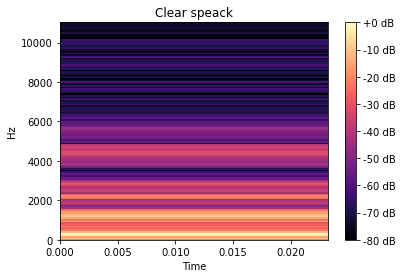

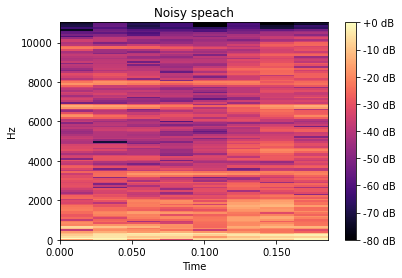

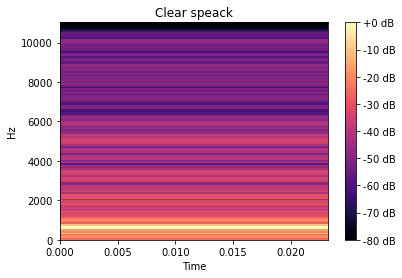

In [26]:

for xb,yb in train_loader:

    for i in range(len(xb)):
        noise_and_speach_stft_abs_db = librosa.amplitude_to_db(xb[1],ref=np.max)
        fig, ax = plt.subplots()
        img = librosa.display.specshow(noise_and_speach_stft_abs_db, y_axis='linear', x_axis='time', ax=ax)
        ax.set_title('Noisy speach')
        fig.colorbar(img, ax=ax, format="%+2.0f dB")

        noise_and_speach_stft_abs_db = librosa.amplitude_to_db(yb[1],ref=np.max)
        fig, ax = plt.subplots()
        img = librosa.display.specshow(noise_and_speach_stft_abs_db, y_axis='linear', x_axis='time', ax=ax)
        ax.set_title('Clear speack')
        fig.colorbar(img, ax=ax, format="%+2.0f dB")

        break
    break

for xb,yb in validation_loader:

    for i in range(len(xb)):
        noise_and_speach_stft_abs_db = librosa.amplitude_to_db(xb[1],ref=np.max)
        fig, ax = plt.subplots()
        img = librosa.display.specshow(noise_and_speach_stft_abs_db, y_axis='linear', x_axis='time', ax=ax)
        ax.set_title('Noisy speach')
        fig.colorbar(img, ax=ax, format="%+2.0f dB")

        noise_and_speach_stft_abs_db = librosa.amplitude_to_db(yb[1],ref=np.max)
        fig, ax = plt.subplots()
        img = librosa.display.specshow(noise_and_speach_stft_abs_db, y_axis='linear', x_axis='time', ax=ax)
        ax.set_title('Clear speack')
        fig.colorbar(img, ax=ax, format="%+2.0f dB")

        break
    break

for xb,yb in test_loader:

    for i in range(len(xb)):
        noise_and_speach_stft_abs_db = librosa.amplitude_to_db(xb[1],ref=np.max)
        fig, ax = plt.subplots()
        img = librosa.display.specshow(noise_and_speach_stft_abs_db, y_axis='linear', x_axis='time', ax=ax)
        ax.set_title('Noisy speach')
        fig.colorbar(img, ax=ax, format="%+2.0f dB")

        noise_and_speach_stft_abs_db = librosa.amplitude_to_db(yb[1],ref=np.max)
        fig, ax = plt.subplots()
        img = librosa.display.specshow(noise_and_speach_stft_abs_db, y_axis='linear', x_axis='time', ax=ax)
        ax.set_title('Clear speack')
        fig.colorbar(img, ax=ax, format="%+2.0f dB")

        break
    break
        

## Model

In [27]:
import torch.nn as nn
import torch.optim as optim

### Hyperparameters

In [28]:
learning_rate = 0.01
num_epochs = 5

In [29]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    def forward(self, x):
        return self.func(x)

In [30]:

model = nn.Sequential(
    Lambda(lambda x: x.view(-1, 1, 129, 8)),
    nn.Conv2d(1, 16, kernel_size=3),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3),
    nn.ReLU(),
    nn.Conv2d(16, 1, kernel_size=3),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d((129,1))
)

device=torch.device("cuda")
model.to(device)

print(f"Using device {device}, (cuda:0 is prefered over CPU).")  

#optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)


Using device cuda, (cuda:0 is prefered over CPU).


In [31]:
def loss_mse(a, b):
    return ((a - b) ** 2).mean()

## Train

In [41]:
def train_model(model, optimizer, num_epochs):

    metrics = defaultdict(list)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # training
        running_loss = 0.0
        running_corrects = 0
        
        model.train()

        for xb,yb in train_loader:
            
            xb,yb=xb.to(device),yb.to(device)

            pred = model(xb)
            
            _, preds = torch.max(pred, 1)            
            loss = loss_mse(pred, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * xb.size(0)
            running_corrects += torch.sum(preds == yb.data).item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = float(running_corrects) / len(train_loader)           

        print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        metrics["train" + "_loss"].append(epoch_loss)
        metrics["train" + "_acc"].append(epoch_acc)

        
        # validation
        running_loss = 0.0
        running_corrects = 0
        
        model.eval()

        for xb,yb in validation_loader:
            xb,yb=xb.to(device),yb.to(device)

            pred=model(xb)

            _, preds = torch.max(pred, 1)            
            loss = loss_mse(pred, yb)

            # statistics
            running_loss += loss.item() * xb.size(0)
            running_corrects += torch.sum(preds == yb.data).item()
            
        epoch_loss = running_loss / len(validation_loader)
        epoch_acc = float(running_corrects) / len(validation_loader)          

        print(f'Validation Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        
        metrics["val" + "_loss"].append(epoch_loss)
        metrics["val" + "_acc"].append(epoch_acc)

        #print(f"Epoch {epoch}: {avg_loss:.3f}")
        
        
        # deep copy the model
        #if epoch_acc > best_acc:
        #    best_acc = epoch_acc
        #    best_model_wts = copy.deepcopy(model.state_dict())
    
    return model.state_dict(), metrics


Epoch 0/4
----------
Training Loss: 9.9805 Acc: 2.1851
Validation Loss: 9.9410 Acc: 2.1851
Epoch 1/4
----------
Training Loss: 9.9716 Acc: 2.1851
Validation Loss: 9.9696 Acc: 2.1851
Epoch 2/4
----------
Training Loss: 9.9673 Acc: 2.1851
Validation Loss: 9.9522 Acc: 2.1851
Epoch 3/4
----------
Training Loss: 9.9640 Acc: 2.1851
Validation Loss: 9.9260 Acc: 2.1851
Epoch 4/4
----------
Training Loss: 9.9615 Acc: 2.1851
Validation Loss: 9.9375 Acc: 2.1851


<Figure size 432x288 with 0 Axes>

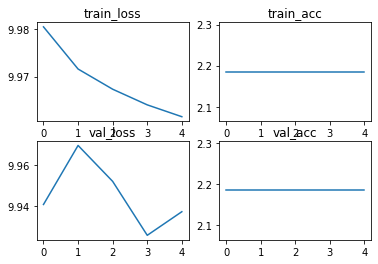

In [42]:


trained_model, metrics = train_model(model, optimizer, num_epochs)


plt.subplots_adjust(wspace=1, hspace=1)
fig, ax = plt.subplots(nrows=2, ncols=2)
keys = list(metrics.keys())
cnt = 0
for row in ax:
    for col in row:
        col.set_title(keys[cnt])
        col.plot(metrics[keys[cnt]])
        cnt += 1
